## Immersive plotting and analyzing results

Lets do some analysis and plotting

In [1]:
import xarray as xr
import pyorc
from matplotlib.colors import Normalize


You have a result stored in a NetCDF file after running notebook 02. Now you want to see if the results seem to make sense, and further analyze these. Especially post-processing of your results with masking invalid velocities is an essential step in most velocimetry analyses, given that sometimes hardly any tracers are visible, and only spuriously correlated results were found. With some intelligence these suspicious velocities can be removed, and `pyorc` has many methods available to do that. Most of these can be applied without any parameter changes for a good result. The order in which mask methods are applied can matter, which we will describe later in this notebook.

Let's first have a look at the file structure. We can simply use the `xarray` API to open the result file.

In [2]:
ds = xr.open_dataset("ngwerere/ngwerere_piv.nc")


As you can see, we have lots of coordinate variables at our disposal, these can be used in turn to plot our data in a local projection, with our bounding box top-left corner at the top-left. The `x` and `y` axes hold the local coordinates. We can also use the UTM35S coordinates, stored in `xs` and `ys`, the longitude and latitude coordinates stored in `lon` and `lat`, or....(very cool) the original row and column coordinate of the camera's objective. This allows us to plot the results as an augmented reality view.

In the data variables, we see `v_x` and `v_y` for the x-directional and y-directional velocity, measured along the `x` and `y` axis of the local coordinate system. Furthermore we see the `s2n` variable containing the signal to noise ratio computed by the underlying used library OpenPIV. This ratio is computed as the ratio between the highest correlation and the second highest correlation found in the surroundings of each window. If this ratio is very low it means that it is difficult to assess which correlation value is the best. We also store the highest correlation found in the variable `corr`. As this is done for each frame to frame pair, the dataset contains 125 time steps, since we extract 126 frames.

Because we used a 0.01 resolution and a 25 pixel interrogation window, and `pyorc` typically uses an overlap between windows of 50%, the `y` and `x` coordinates have a spacing of `25 * 0.01 * 0.5 = 0.125 cm` (rounded to 0.13).

Finally, a lot of attributes are stored in a serializable form, so that the dataset can be stored in NetCDF, and the camera configuration and other information needed can be used by our postprocessing and plotting methods after loading. Normally, you don't have to worry about all these details and simply use the methods in `pyorc` to deal with them.


### Plotting in local projection
Both a frames `DataArray` and a velocimetry `Dataset` have plotting functionalities that can be used to combine information into a plot. The default is to plot data in the local projection that follows the area of interest bounding box, but geographical plots or camera perspectives can also be plotted. Let's start with an rgb frame with the PIV results on top. We cannot plot the time dimension, so we apply a `mean` reducer first. To prevent that all metadata of the variables gets lost in this process, the `keep_attrs=True` flag is applied.

Note that whilst plotting velocimetry results, we can supply `kwargs_scalar` and `kwargs_quiver`. These are meant to pass arguments to plotting of the scalar velocity values (plotted as a mesh) and the vectors (plotted as arrows).

Scanning video: 100%|██████████| 126/126 [00:05<00:00, 21.08it/s]


MemoryError: Unable to allocate 314. MiB for an array with shape (20, 3, 785, 875) and data type float64

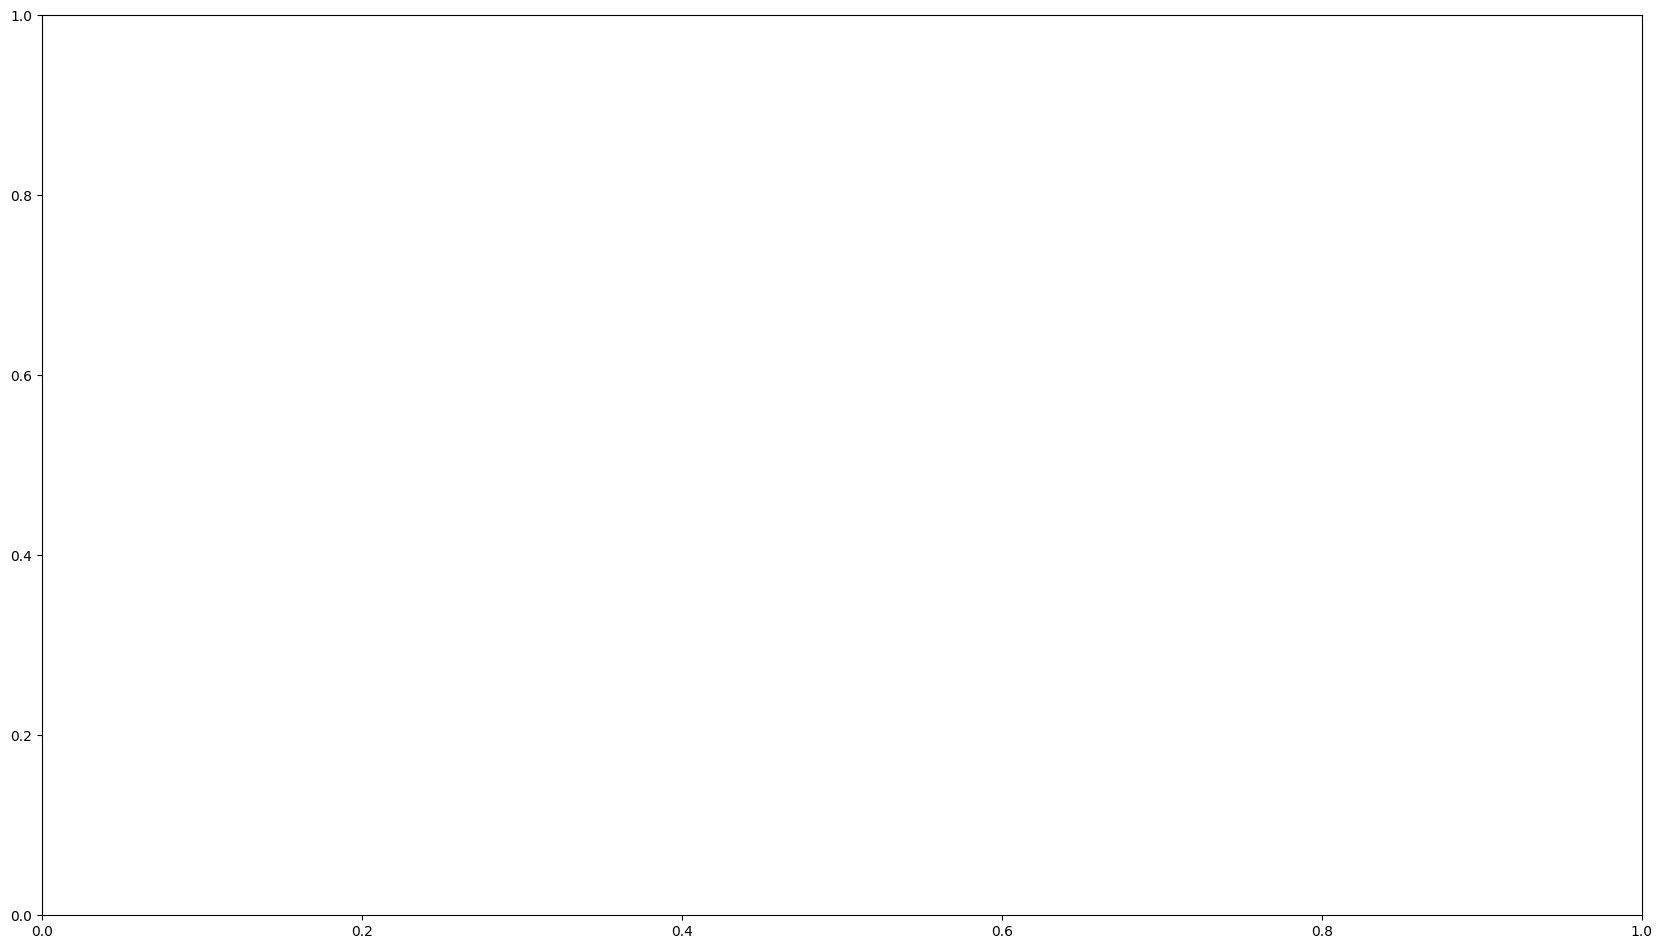

In [3]:
# first re-open the original video, extract one RGB frame and plot that
video_file = "ngwerere/ngwerere_20191103.mp4"

video = pyorc.Video(video_file, start_frame=0, end_frame=125)
# borrow the camera config from the velocimetry results
video.camera_config = ds.velocimetry.camera_config

da_rgb = video.get_frames(method="rgb")
# project the rgb frame
da_rgb_proj = da_rgb.frames.project()
# plot the first frame (we only have one) without any arguments, default is to use "local" mode
p = da_rgb_proj[0].frames.plot()

# now plot the results on top, we use the mean, because we cannot plot more than 2 dimensions. 
# Default plotting method is "quiver", but "scatter" or "pcolormesh" is also possible.
# We add a nice colorbar to understand the magnitudes.
# We give the existing axis handle of the mappable returned from .frames.plot to plot on, and use 
# some transparency.
ds_mean = ds.mean(dim="time", keep_attrs=True)

# first a pcolormesh
ds_mean.velocimetry.plot.pcolormesh(
    ax=p.axes,
    alpha=0.3,
    cmap="rainbow",
    add_colorbar=True,
    vmax=0.6
)

ds_mean.velocimetry.plot(
    ax=p.axes,
    color="w",
    alpha=0.5,
)


### Masking of results
Already this looks very promising. But we haven't yet analyzed any of the velocities for spurious values. Even over land we have estimates of velocities, while there is no moving water there. We have a set of temporal masking methods which analyze for spurious values by comparing over time steps, and spatial masking methods, which compare neighbouring grid cell values to flag spurious values. These are defined under a subclass in ``ds.velocimetry.mask``. 

The mask methods all return a xr.DataArray with the same size as the DataArray variables in the dataset and can be applied in two ways:

- first defining several masks, without applying these on the dataset, and then collectively apply them. This is the default behaviour. Masks can be collectively applied with ``ds.velocimetry.mask([mask1, mask2, mask3, ...])``.
- apply the mask immediately on the dataset (use ``inplace=True`` on each mask method).

In the last case, you should be aware that applying another mask method after having applied other mask methods makes the results conditional on masks already applied. Therefore in this case the order in which you apply masks will change the results. For instance, if you first mask out velocities that are outside a minimum / maximum velocity range using ``ds.velocimetry.mask.minmax``, and only after that mask out based on variance in time (points with a high variance can be masked), the computed variance over time for each location will likely already be lower, because you may have excluded outlier velocities. The method ``ds.velocimetrry.mask.count`` simply counts how many values are found per grid cell, relative to the total amount of time steps available. This method typically requires that you first apply a set of other mask methods, before being applied.

Below, we decided to apply masks in a certain order, and conditional on each other. We start with masks that can typically be applied on individual values, such as the ``minmax`` and ``corr``. And then gradually move to masks that require analysis of all values in time, such as the ``variance`` method and (see above) the ``count`` method. This is typically the good practice.


In [ ]:
import copy
ds_mask = copy.deepcopy(ds)
mask_corr = ds_mask.velocimetry.mask.corr(inplace=True)
mask_minmax = ds_mask.velocimetry.mask.minmax(inplace=True)
mask_rolling = ds_mask.velocimetry.mask.rolling(inplace=True)
mask_outliers = ds_mask.velocimetry.mask.outliers(inplace=True)
mask_var = ds_mask.velocimetry.mask.variance(inplace=True)
mask_angle = ds_mask.velocimetry.mask.angle(inplace=True)
mask_count = ds_mask.velocimetry.mask.count(inplace=True)


# apply the plot again, let's leave out the scalar values, and make the quivers a bit nicer than before.
ds_mean_mask = ds_mask.mean(dim="time", keep_attrs=True)


# again the rgb frame first
p = da_rgb_proj[0].frames.plot()

#...and then masked velocimetry
ds_mean_mask.velocimetry.plot(
    ax=p.axes,
    alpha=0.4,
    norm=Normalize(vmax=0.6, clip=False),
    add_colorbar=True
)


Interesting! We see that the velocities become a lot higher on average. Most likely because many spurious velocities are removed. We also see that the velocities seem to be more left-to-right oriented. In part this may be because we applied the `.mask.angle` method. This mask removes velocities that are in a direction, far off from the expected flow direction. The default direction of this mask is always left to right. Therefore take good care of this mask, if you decide to e.g. apply `pyorc` in a bottom to top direction.

As this stream is very shallow and has lots of obstructions like rocks that the water goes around, the application of this mask may have removed many velocities that were actually correct. Let's do the masking again, but relaxing the tolerance of the angle mask.

Besides this, we can also apply a number of spatial masks. It is often logical to apply these on the mean of the dataset in time. This can be done by adding the ``reduce_time`` flag. Note that ``reduce_time`` can in principle also be used on any other mask that does not per se require ``time`` as a dimension. The spatial mask we demonstrate here compares the value under consideration against a window mean around that location. If the window mean (after reducing the ``time`` dimension with a mean) is very different, the value at that location will be excluded.


In [ ]:
# apply all methods in time domain with relaxed angle masking
import numpy as np
ds_mask2 = copy.deepcopy(ds)
ds_mask2.velocimetry.mask.corr(inplace=True)
ds_mask2.velocimetry.mask.minmax(inplace=True)
ds_mask2.velocimetry.mask.rolling(inplace=True)
ds_mask2.velocimetry.mask.outliers(inplace=True)
ds_mask2.velocimetry.mask.variance(inplace=True)
ds_mask2.velocimetry.mask.angle(angle_tolerance=0.5*np.pi)
ds_mask2.velocimetry.mask.count(inplace=True)
ds_mask2.velocimetry.mask.window_mean(wdw=2, inplace=True, tolerance=0.5, reduce_time=True)

# Now first average in time before applying any filter that only works in space.
ds_mean_mask2 = ds_mask2.mean(dim="time", keep_attrs=True)

# apply the plot again
# again the rgb frame first
p = da_rgb_proj[0].frames.plot()

#...and then filtered velocimetry
ds_mean_mask2.velocimetry.plot(
    ax=p.axes,
    alpha=0.4,
    norm=Normalize(vmax=0.6, clip=False),
    add_colorbar=True
)


It looks more natural. Check for instance the pattern around the rock on the left side. Now we can also plot in a geographical view.

In [ ]:
# again the rgb frame first. But now we use the "geographical" mode to plot on a map
p = da_rgb_proj[0].frames.plot(mode="geographical")

#...and then masked velocimetry again, but also geographical
ds_mean_mask2.velocimetry.plot(
    ax=p.axes,
    mode="geographical",
    alpha=0.4,
    norm=Normalize(vmax=0.6, clip=False),
    add_colorbar=True
)

# for fun, let's also add a satellite background from cartopy
import cartopy.io.img_tiles as cimgt
import cartopy.crs as ccrs
tiles = cimgt.GoogleTiles(style="satellite")
p.axes.add_image(tiles, 19)
# zoom out a little bit so that we can actually see a bit
p.axes.set_extent([
    da_rgb_proj.lon.min() - 0.00005,
    da_rgb_proj.lon.max() + 0.00005,
    da_rgb_proj.lat.min() - 0.00005,
    da_rgb_proj.lat.max() + 0.00005],
    crs=ccrs.PlateCarree()
)


### Immersive and intuitive augmented reality
And now the most beautiful plot you can make with pyorc: an augmented reality view. For this, we need an unprojected rgb frame and supply the `mode="camera"` keyword argument.

In [ ]:
# again the rgb frame first, but now the unprojected one. Now we use the "camera" mode to plot the camera perspective
p = da_rgb[0].frames.plot(mode="camera")

#...and then masked velocimetry again, but also camera. This gives us an augmented reality view. The quiver scale 
# needs to be adapted to fit in the screen properly
ds_mean_mask.velocimetry.plot(
    ax=p.axes,
    mode="camera",
    alpha=0.4,
    norm=Normalize(vmin=0., vmax=0.6, clip=False),
    add_colorbar=True
)


### Store the final masked results
Let's also store the masked velocities in a separate file. To ensure it remains really small, we can use the `.set_encoding` method first, to ensure the variables are encoded to integer values before storing. This makes the file nice and small.

In [ ]:
ds_mask2.velocimetry.set_encoding()
ds_mask2.to_netcdf("ngwerere_masked.nc")